In [21]:
library(tidyverse)
library(gridExtra)
library(pROC)

### 1. 读入数据并了解自变量含义

In [2]:
dataRaw <- read.csv('simudata.csv')
head(dataRaw)

creded,debitF,meanpay,billnum,debitM,zhongxingM,sidaM,xindaiR,cardnum,xindaiF,...,sidaR,zhongxingF,zhongxingR,xiaofeiF,jinkaF,zhuanzhangM,gongjiaoM,youxiM,xindaiS,black
0.02,28,474795,4,784137.54,56826,307042,365.00,2,6,...,7.83,4,334.38,6,9,508646.0,297.83,66.02,5760.22,1
0.16,2,346573,32,1217.43,43644,15096,311.73,9,0,...,91.77,14,365.00,1,11,425876.2,3521.03,22.75,83872.62,1
0.32,56,168844,191,95001.76,279217,69815,42.32,8,0,...,36.05,10,27.08,1,2,492287.8,467.64,6.66,31110.55,1
0.01,28,69002,89,487782.48,273731,329437,81.60,15,1,...,10.08,8,191.04,1,8,240067.3,288.67,119.98,7876.13,1
0.19,6,408647,104,22039.56,13529,24725,254.60,17,9,...,324.21,23,248.39,7,0,455464.5,11834.25,28.97,13765.38,0
0.20,65,285313,3,194798.70,11285,17961,50.31,5,0,...,237.08,0,361.47,4,0,192392.7,527.81,27.45,161711.43,0


所有自变量的意义如下：

age	年龄

cardnum	银行卡数

creded	借贷比率

billnum	交易笔数

meanpay	所有行为均值

maxpay	所有行为最大值

xiaofeiF	消费类消费频率

jinkaF	金卡类消费频率

youxiM	游戏类消费金额平均值

debitM	借记类消费金额平均值

debitF	借记类消费频率

gongjiaoR	公缴类最近一次消费

gongjiaoF	公缴类消费频率

gongjiaoM	公缴类金额平均值

zhongxingR	中型银行最近一次消费

zhongxingF	中型银行消费频率

zhongxingM	中型银行金额平均值

sidaR	四大行最近一次消费

sidaF	四大行消费频率

sidaM	四大行金额平均值

zhuanzhangR	转账类最近一次消费

zhuanzhangF	转账类消费频率

zhuanzhangM	转账类金额平均值

xindaiR	信贷类最近一次消费

xindaiF	信贷类消费频率

xindaiS	信贷类消费波动性

### 2. 多种机器学习模型进行建模

In [18]:
set.seed(1234)
SELECT <- sample(0:nrow(dataRaw), size=nrow(dataRaw))
dataTrain <- dataRaw[SELECT[1:(nrow(dataRaw)*0.7)],]
dataTest <- dataRaw[SELECT[-(1:(nrow(dataRaw)*0.7))],]
# dataTrain$black <- as.factor(dataTrain$black)

#### - Logistic Regression

Setting levels: control = 0, case = 1
Setting direction: controls < cases


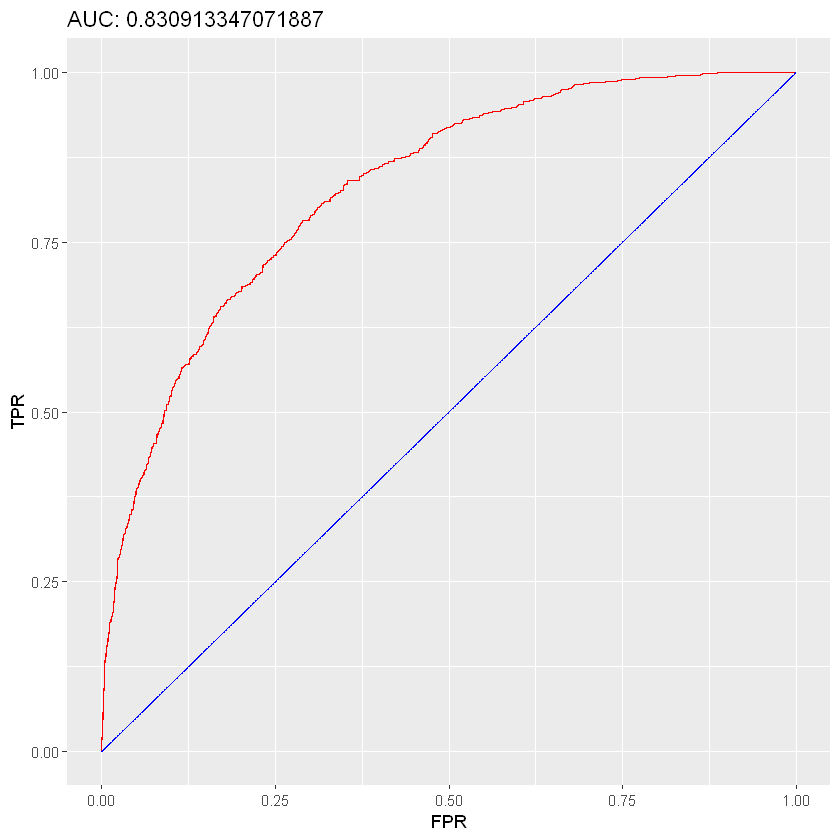

In [4]:
logModel <- glm(data=dataTrain, formula=black~., family='binomial')
logPred <- predict(object=logModel, newdata=dataTest, type='response')
logROC <- roc(dataTest$black, logPred, plot.roc=T)
ggplot(mapping=aes(x=1-logROC$specificities, y=logROC$sensitivities)) + geom_line(
    color='red') + geom_line(
    color='blue', aes(x=logROC$specificities,y=logROC$specificities)) + labs(
    x='FPR', y='TPR', title=paste('AUC:',logROC$auc))

#### - Decision Tree

Setting levels: control = 0, case = 1
Setting direction: controls > cases


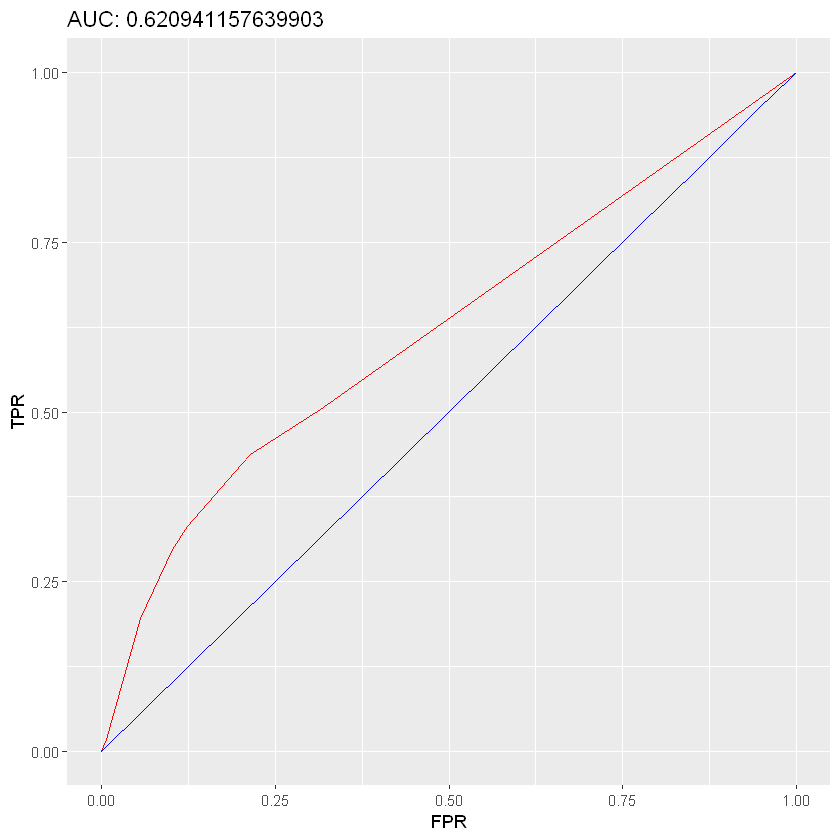

In [19]:
library(rpart)
treeModel <- rpart(data=dataTrain, formula=black~., method='class')
treePred <- predict(object=treeModel, newdata=dataTest)[,1]
treeROC <- roc(dataTest$black, treePred)
ggplot(mapping=aes(x=1-treeROC$specificities, y=treeROC$sensitivities)) + geom_line(
    color='red') + geom_line(
    color='blue', aes(x=treeROC$specificities,y=treeROC$specificities)) + labs(
    x='FPR', y='TPR', title=paste('AUC:',treeROC$auc))

#### - Boosting模型

Distribution not specified, assuming bernoulli ...


Using 100 trees...

Setting levels: control = 0, case = 1
Setting direction: controls < cases


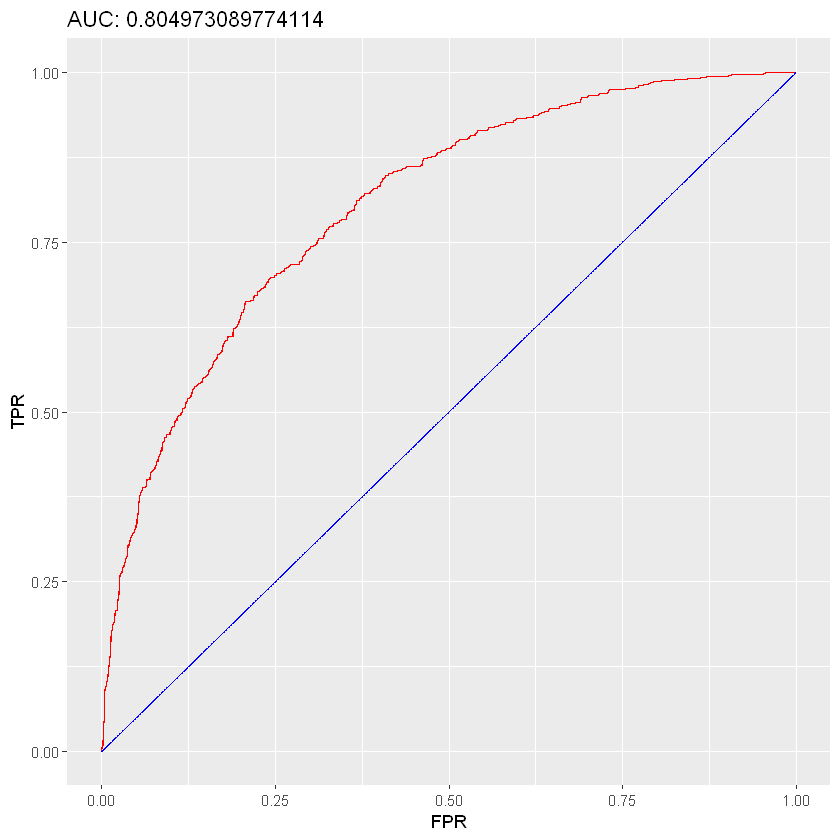

In [17]:
library(gbm)
boostModel <-  gbm(data=dataTrain, formula=black~.)
boostPred <- predict(object=boostModel, newdata=dataTest)
boostROC <- roc(as.numeric(dataTest$black), as.numeric(boostPred))
ggplot(mapping=aes(x=1-boostROC$specificities, y=boostROC$sensitivities)) + geom_line(
    color='red') + geom_line(
    color='blue', aes(x=boostROC$specificities,y=boostROC$specificities)) + labs(
    x='FPR', y='TPR', title=paste('AUC:',boostROC$auc))

#### - Random Forest

Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"Setting levels: control = 0, case = 1
Setting direction: controls < cases


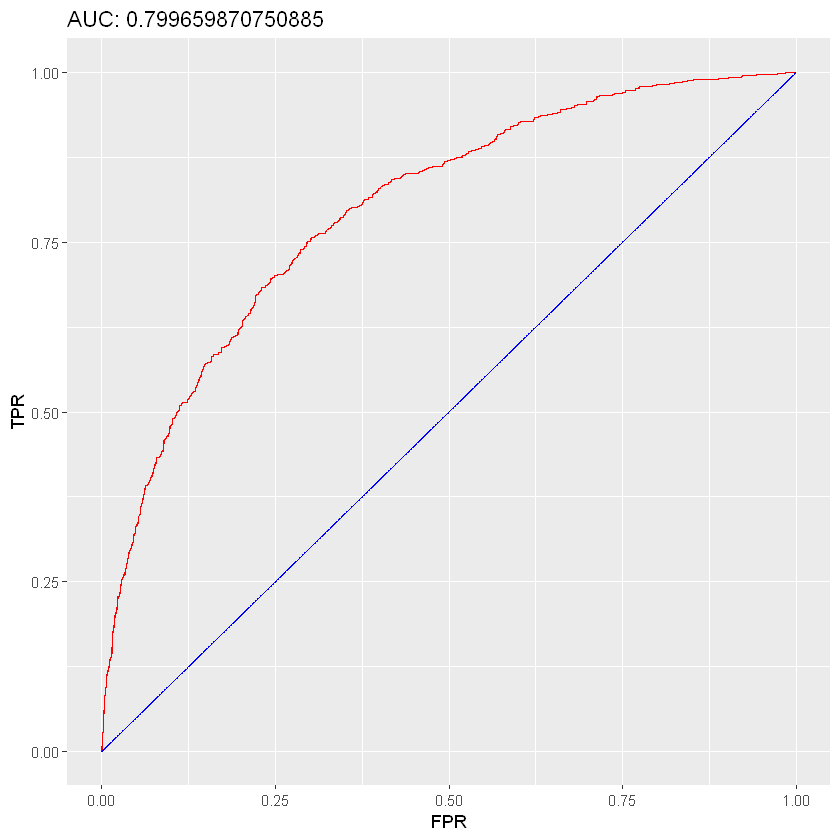

In [16]:
library(randomForest)
forestModel <- randomForest(black~., data=dataTrain, importance=T)
forestPred <- predict(object=forestModel, newdata=dataTest)
forestROC <- roc(dataTest$black, as.numeric(forestPred))
ggplot(mapping=aes(x=1-forestROC$specificities, y=forestROC$sensitivities)) + geom_line(
    color='red') + geom_line(
    color='blue', aes(x=forestROC$specificities,y=forestROC$specificities)) + labs(
    x='FPR', y='TPR', title=paste('AUC:', forestROC$auc))

#### - SVM

Warning message:
"package 'e1071' was built under R version 3.6.3"Setting levels: control = 0, case = 1
Setting direction: controls < cases


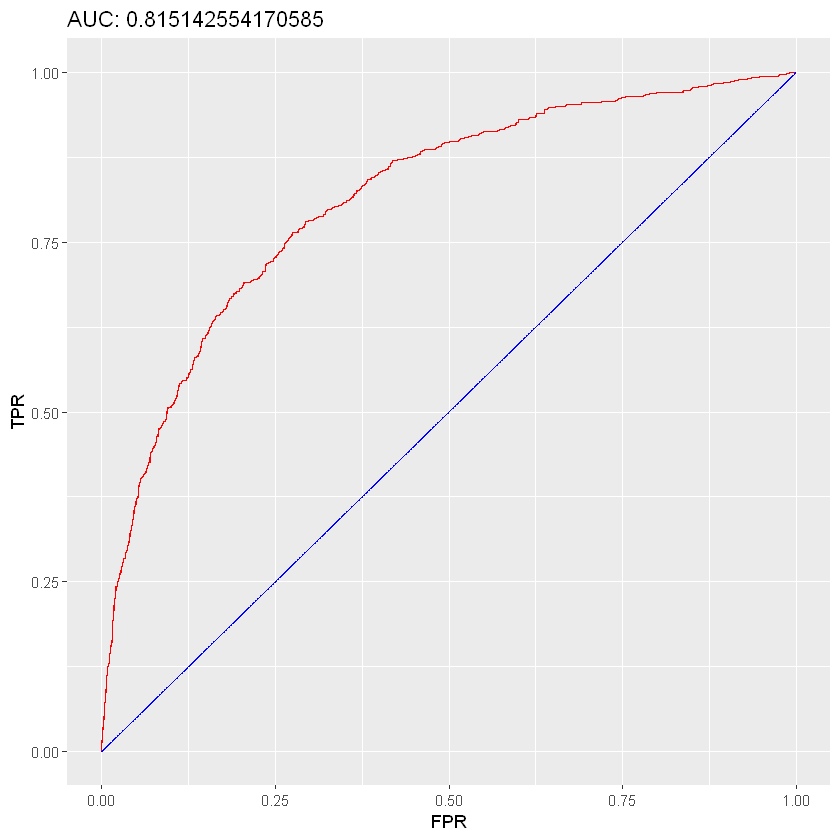

In [20]:
library(e1071)
svmModel <- svm(black~., data=dataTrain, importance=T)
svmPred <- predict(object=svmModel, newdata=dataTest)
svmROC <- roc(dataTest$black, svmPred)
ggplot(mapping=aes(x=1-svmROC$specificities, y=svmROC$sensitivities)) + geom_line(
    color='red') + geom_line(
    color='blue', aes(x=svmROC$specificities,y=svmROC$specificities)) + labs(
    x='FPR', y='TPR', title=paste('AUC:', svmROC$auc))

### 3. 选择一个最优的模型

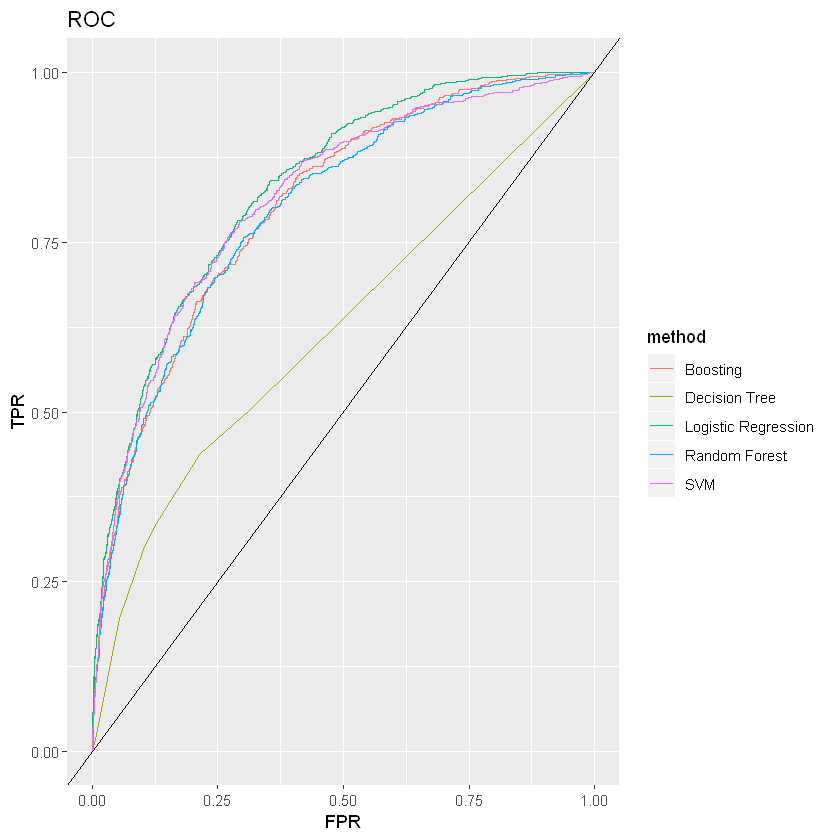

In [62]:
ROC <- data.frame(FPR=c(1-logROC$specificities, 1-boostROC$specificities, 1-treeROC$specificities, 
                        1-forestROC$specificities, 1-svmROC$specificities), 
                  TPR=c(logROC$sensitivities, boostROC$sensitivities, treeROC$sensitivities, 
                        forestROC$sensitivities, svmROC$sensitivities),
                  method=c(rep('Logistic Regression', length(logROC$sensitivities)), 
                           rep('Boosting', length(boostROC$sensitivities)), 
                           rep('Decision Tree', length(treeROC$sensitivities)), 
                           rep('Random Forest', length(forestROC$sensitivities)), 
                           rep('SVM', length(svmROC$sensitivities))))
ggplot(ROC, aes(x=FPR, y=TPR, group=method, color=method)) + geom_line() + geom_abline(
    color='black', intercept=0, slope=1) + labs(title="ROC")

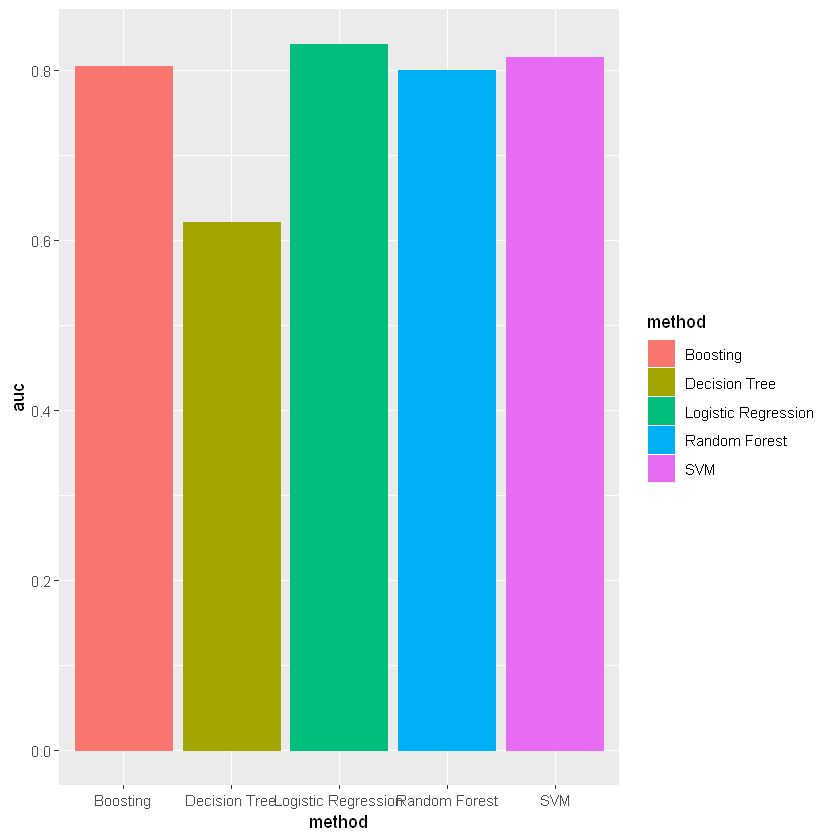

In [81]:
AUC <- data.frame(method=c('Logistic Regression', 'Boosting', 'Decision Tree', 'Random Forest', 'SVM'), 
                  auc=c(logROC$auc, boostROC$auc, treeROC$auc, forestROC$auc, svmROC$auc))
ggplot(AUC) + geom_bar(aes(x=method, y=auc, color=method, fill=method), stat='identity')

从ROC曲线的形状来看，Boosting、逻辑回归、支持向量机和随机森林的分类效果几乎差不多，而决策树的效果差的很远。随机森林的树数量很多，比一个决策树的分类效果好是必然的，而其它模型也表明它们在这个问题上分类效果不错。从AUC结果看，逻辑回归以0.8309成为了最优的分类器，这也说明简单的模型很有可能是最好的模型。

综上，我们选择逻辑回归作为最好的模型。